In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader, random_split, TensorDataset   # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import timeit
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix

## Neural Network Model

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes, init_type="normal"):
        super(NN, self).__init__()
        self.init_type = init_type
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, num_classes)        
        self.initialize_weights()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        sm = nn.Softmax(dim=1)
        x = sm(self.fc3(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if ( self.init_type == "normal"):
                    nn.init.normal_(m.weight)
                elif ( self.init_type == "uniform"):
                    nn.init.uniform_(m.weight)
                elif ( self.init_type == "xavier"):
                    nn.init.xavier_uniform(m.weight)
                nn.init.constant_(m.bias, 0)


### Setting device to GPU to speed up

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### Hyperparameters of our neural network which depends on the dataset

In [ ]:

input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

#### Loading training and testing dataset

In [ ]:
# Load Training and Test data
batch_size = 64
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_dataset, valid_dataset = random_split(train_dataset,[50000,10000])
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


#### Training with validation

In [ ]:
def TRAIN(model, criterion, optimizer, num_epoch=5):
  start = timeit.default_timer()
  accuracy = []
  train_loss = []
  valid_loss = []
  # Train Network
  for epoch in range(num_epoch):
      tr_loss = 0.0
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to cuda if possible
          data = data.to(device=device)
          targets = targets.to(device=device)

          # Get to correct shape
          data = data.reshape(data.shape[0], -1)

          # forward
          scores = model(data)
          loss = criterion(scores, targets)
          #print(epoch, loss)
          # backward
          optimizer.zero_grad()
          loss.backward()
          
          # gradient descent or adam step
          optimizer.step()
          tr_loss += loss.item()
      Loss = tr_loss / len(train_loader)
      #print(Loss)
      train_loss.append(Loss)

      #---------  VALIDATION STEP------------------------------------
      val_loss = 0.0
      model.eval()     # Optional when not using Model Specific layer
      for data, labels in valid_loader:
          if torch.cuda.is_available():
              data, labels = data.cuda(), labels.cuda()
          data = data.reshape(data.shape[0], -1)
          target = model(data)
          loss = criterion(target,labels)
          val_loss += loss.item() #* data.size(0)
      val_loss /= len(valid_loader) 
      valid_loss. append(val_loss)
      #print(val_loss)
      #--------------------------------------------------------------
      #------------- Accuracy at this epoch -------------------------
      acc = check_accuracy(test_loader, model)*100
      accuracy.append(acc)
      #--------------------------------------------------------------
      print("\nEpoch : ",epoch,"  Train Loss : ",Loss,"  Validation Loss : ",val_loss,"  Accuracy : ",acc,"\n")
  stop = timeit.default_timer()
  print('Time: ', stop - start)  
  return train_loss, valid_loss, accuracy


#### Funtion to calculate accuracy of model

In [ ]:

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct/num_samples



#### Reseting parameters of model

In [ ]:
def reset_network_params(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()


#### Saving and loading a model

In [ ]:
def save_checkpoint(state, filename="/content/drive/My Drive/my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


#### Function to plot Train loss and validation loss per epoch

In [ ]:
def plot_losses(train_loss, valid_loss):
  plt.plot(train_loss, '-bx')
  plt.plot(valid_loss, '-rx')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(['Training', 'Validation'])
  plt.title("Loss vs Epoch")

#### Funtion to plot accuracy per epoch during training

In [ ]:
def plot_accuracy(accuracy, num_epoch=30):
  plt.plot(accuracy, '-ro')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epoch")

#### Funtion to show confusion matrix

In [ ]:
import seaborn as sns
# Check accuracy on training & test to see how good our model
def get_confusion_matrix(loader, model):
    with torch.no_grad():
        pred = np.zeros(1)
        actual = np.zeros(1)
        for x, y in loader:
            actual = np.append(actual, y.numpy())
            x = x.to(device=device)
            y = y.to(device=device)
            #print(x.shape,y.shape)
            x = x.reshape(x.shape[0], -1)
            scores = model(x)
            #print("11")
            _, predictions = scores.max(1)
            #print("22")
            pred = np.append(pred, predictions.cpu().data.numpy())
 
    actual = actual[1:]
    pred = pred[1:]
    #print(actual.shape, pred.shape)
    #print(type(actual), type(pred),pred)
    actual = actual.astype(int)
    pred = pred.astype(int)
    cf_mat = confusion_matrix(list(actual), list(pred) )
    plt.figure(figsize=(9,9))
    sns.heatmap(cf_mat, annot=True)


## Part - 1
### 1. Perform the experiment using different optimizers like Adam, RMSProp, SGD with momentum, SGD without momentum.

#### Optimizer : Adam
#### Weight Initialization : Uniform

In [ ]:
# Initialize network
model = NN(input_size=input_size, num_classes=num_classes, init_type="uniform").to(device)
reset_network_params(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss, valid_loss, accuracy = TRAIN(model, criterion, optimizer, num_epoch=20)


  2%|▏         | 18/782 [00:00<00:04, 174.20it/s]


Epoch :  0   Train Loss :  1.6244022048952635   Validation Loss :  1.5456159578007498   Accuracy :  tensor(93.1400, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.80it/s]


Epoch :  1   Train Loss :  1.53370482080123   Validation Loss :  1.5316615294499003   Accuracy :  tensor(93.7700, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 181.32it/s]


Epoch :  2   Train Loss :  1.520186114189265   Validation Loss :  1.5230162614470075   Accuracy :  tensor(94.6900, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 179.52it/s]


Epoch :  3   Train Loss :  1.5121813259466226   Validation Loss :  1.5185022414869564   Accuracy :  tensor(95.0400, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.12it/s]


Epoch :  4   Train Loss :  1.5067861862194813   Validation Loss :  1.513801889814389   Accuracy :  tensor(95.5700, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.81it/s]


Epoch :  5   Train Loss :  1.5029366615483217   Validation Loss :  1.5097718808301694   Accuracy :  tensor(95.8200, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 187.97it/s]


Epoch :  6   Train Loss :  1.4990326591464869   Validation Loss :  1.5042096285303688   Accuracy :  tensor(96.1200, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 186.82it/s]


Epoch :  7   Train Loss :  1.495367820458034   Validation Loss :  1.5037335309253377   Accuracy :  tensor(96.2000, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.75it/s]


Epoch :  8   Train Loss :  1.492662066388923   Validation Loss :  1.5038075173736378   Accuracy :  tensor(96.0200, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 192.76it/s]


Epoch :  9   Train Loss :  1.4899106278748768   Validation Loss :  1.5031331079021382   Accuracy :  tensor(96.1300, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 184.88it/s]


Epoch :  10   Train Loss :  1.488454428932551   Validation Loss :  1.4985228541550364   Accuracy :  tensor(96.3900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 193.54it/s]


Epoch :  11   Train Loss :  1.487943374592325   Validation Loss :  1.5011358967252597   Accuracy :  tensor(96.3500, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 184.94it/s]


Epoch :  12   Train Loss :  1.4860046223911179   Validation Loss :  1.4986632234731299   Accuracy :  tensor(96.5500, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 173.68it/s]


Epoch :  13   Train Loss :  1.4848474948607442   Validation Loss :  1.497699855239528   Accuracy :  tensor(96.5900, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 174.69it/s]


Epoch :  14   Train Loss :  1.4833122147318651   Validation Loss :  1.4987421620423627   Accuracy :  tensor(96.6400, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.13it/s]


Epoch :  15   Train Loss :  1.4829238976359063   Validation Loss :  1.497144482697651   Accuracy :  tensor(96.6100, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 158.01it/s]


Epoch :  16   Train Loss :  1.481724520473529   Validation Loss :  1.4976154588590003   Accuracy :  tensor(96.7900, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 177.98it/s]


Epoch :  17   Train Loss :  1.480659865662265   Validation Loss :  1.4988232782691906   Accuracy :  tensor(96.8300, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 149.57it/s]


Epoch :  18   Train Loss :  1.4804763886934655   Validation Loss :  1.4960043164575176   Accuracy :  tensor(96.8100, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 163.66it/s]



Epoch :  19   Train Loss :  1.479770516343129   Validation Loss :  1.4955918743352221   Accuracy :  tensor(96.9000, device='cuda:0') 

Time:  115.89273068099999


In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 98.47
Accuracy on test set: 96.90


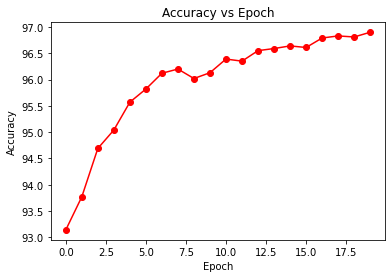

In [ ]:
plot_accuracy(accuracy, num_epoch=20)

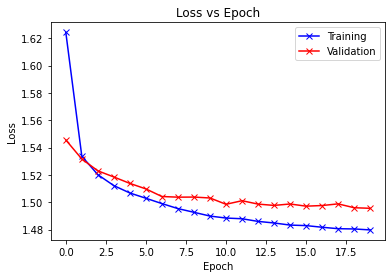

In [ ]:
plot_losses(train_loss, valid_loss) 

#### Optimizer : SGD with momentum
#### Weight Initialization : Normal

In [ ]:
# Initialize network
model1 = NN(input_size=input_size, num_classes=num_classes, init_type="normal").to(device)
reset_network_params(model1)

# Loss and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.25, momentum=0.3, nesterov=False)
train_loss, valid_loss, accuracy = TRAIN(model1, criterion1, optimizer1, num_epoch=25)


  2%|▏         | 19/782 [00:00<00:04, 188.84it/s]


Epoch :  0   Train Loss :  1.777998571200749   Validation Loss :  1.589086492350147   Accuracy :  tensor(89.2100, device='cuda:0') 



  3%|▎         | 21/782 [00:00<00:03, 201.09it/s]


Epoch :  1   Train Loss :  1.5561566686691226   Validation Loss :  1.5608291838579118   Accuracy :  tensor(91.5500, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 158.92it/s]


Epoch :  2   Train Loss :  1.5368126646027236   Validation Loss :  1.536558756403103   Accuracy :  tensor(93.0400, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 199.23it/s]


Epoch :  3   Train Loss :  1.52470634904359   Validation Loss :  1.52673182897507   Accuracy :  tensor(93.8900, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 184.93it/s]


Epoch :  4   Train Loss :  1.5159240218684495   Validation Loss :  1.5199728391732379   Accuracy :  tensor(94.6300, device='cuda:0') 



  3%|▎         | 21/782 [00:00<00:03, 202.88it/s]


Epoch :  5   Train Loss :  1.509574018323513   Validation Loss :  1.5118464003702639   Accuracy :  tensor(95.5000, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.58it/s]


Epoch :  6   Train Loss :  1.5050028250040606   Validation Loss :  1.5108968938232228   Accuracy :  tensor(95.3400, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 197.96it/s]


Epoch :  7   Train Loss :  1.501814872864872   Validation Loss :  1.5095279026942647   Accuracy :  tensor(95.5900, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 184.92it/s]


Epoch :  8   Train Loss :  1.4986687519056412   Validation Loss :  1.5030852647344017   Accuracy :  tensor(96.0800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 199.98it/s]


Epoch :  9   Train Loss :  1.4956877446540482   Validation Loss :  1.5093723489980029   Accuracy :  tensor(95.5500, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.33it/s]


Epoch :  10   Train Loss :  1.4939282387113937   Validation Loss :  1.503846329488572   Accuracy :  tensor(96.0700, device='cuda:0') 



  3%|▎         | 21/782 [00:00<00:03, 201.91it/s]


Epoch :  11   Train Loss :  1.491433590879221   Validation Loss :  1.5000171798050024   Accuracy :  tensor(96.3600, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 158.67it/s]


Epoch :  12   Train Loss :  1.4899622983944691   Validation Loss :  1.5011398701151466   Accuracy :  tensor(96.3200, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 153.70it/s]


Epoch :  13   Train Loss :  1.4881869443237323   Validation Loss :  1.4978905711204382   Accuracy :  tensor(96.5200, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.30it/s]


Epoch :  14   Train Loss :  1.4870385353827416   Validation Loss :  1.4977410477437791   Accuracy :  tensor(96.5200, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 194.61it/s]


Epoch :  15   Train Loss :  1.4855723289577552   Validation Loss :  1.4971686677568277   Accuracy :  tensor(96.5000, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 154.92it/s]


Epoch :  16   Train Loss :  1.4849133020471734   Validation Loss :  1.495161326827517   Accuracy :  tensor(96.7900, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 165.97it/s]


Epoch :  17   Train Loss :  1.483586890465768   Validation Loss :  1.4989593894618332   Accuracy :  tensor(96.4200, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 174.82it/s]


Epoch :  18   Train Loss :  1.48257073203621   Validation Loss :  1.4949059008033412   Accuracy :  tensor(96.9700, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 197.36it/s]


Epoch :  19   Train Loss :  1.4817062370917375   Validation Loss :  1.4937741247711667   Accuracy :  tensor(96.8300, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 198.31it/s]


Epoch :  20   Train Loss :  1.4812366213944868   Validation Loss :  1.4982981780532059   Accuracy :  tensor(96.4800, device='cuda:0') 



  3%|▎         | 21/782 [00:00<00:03, 200.70it/s]


Epoch :  21   Train Loss :  1.4802631755619098   Validation Loss :  1.4941024696751006   Accuracy :  tensor(96.9900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 195.98it/s]


Epoch :  22   Train Loss :  1.479275634679038   Validation Loss :  1.4925735885170615   Accuracy :  tensor(97.0700, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 164.21it/s]


Epoch :  23   Train Loss :  1.4782976854182874   Validation Loss :  1.4948784743145014   Accuracy :  tensor(96.9400, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 176.52it/s]



Epoch :  24   Train Loss :  1.4778875812240269   Validation Loss :  1.4926885685343652   Accuracy :  tensor(97.0200, device='cuda:0') 

Time:  140.72170025499997


In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model1)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model1)*100:.2f}")

Accuracy on training set: 98.42
Accuracy on test set: 97.02


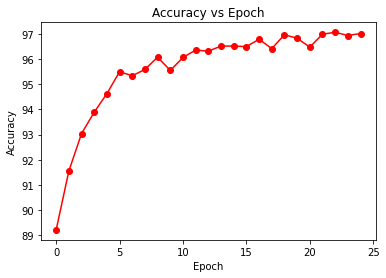

In [ ]:
plot_accuracy(accuracy, num_epoch=25)

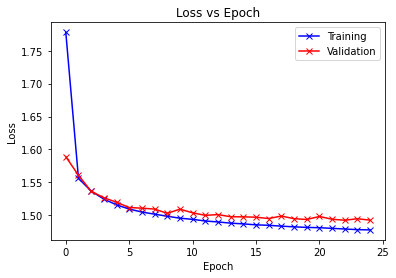

In [ ]:
plot_losses(train_loss, valid_loss) 

#### Optimizer : SGD with momentum + Nesterov method
#### Weight Initialization : Xavier

In [ ]:
# Initialize network
model2 = NN(input_size=input_size, num_classes=num_classes, init_type="xavier").to(device)
reset_network_params(model2)

# Loss and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.7, nesterov=True)
train_loss, valid_loss, accuracy = TRAIN(model2, criterion2, optimizer2, num_epoch=25)

#train_loss, valid_loss, accuracy = train_model(model2, criterion2, optimizer2, num_epoch=6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  2%|▏         | 15/782 [00:00<00:05, 148.54it/s]


Epoch :  0   Train Loss :  2.3019966847451445   Validation Loss :  2.3015873477717115   Accuracy :  tensor(12.3300, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 157.90it/s]


Epoch :  1   Train Loss :  2.3011961218036348   Validation Loss :  2.300769168100539   Accuracy :  tensor(13.1300, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 198.96it/s]


Epoch :  2   Train Loss :  2.30026842718539   Validation Loss :  2.2997586863815407   Accuracy :  tensor(14.4500, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 187.24it/s]


Epoch :  3   Train Loss :  2.299142409773434   Validation Loss :  2.2985062006932155   Accuracy :  tensor(17.2700, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 156.32it/s]


Epoch :  4   Train Loss :  2.297734220314514   Validation Loss :  2.2969440563469177   Accuracy :  tensor(21.8600, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 154.11it/s]


Epoch :  5   Train Loss :  2.2959711249831996   Validation Loss :  2.295006735309674   Accuracy :  tensor(25.5100, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 193.94it/s]


Epoch :  6   Train Loss :  2.293718239535456   Validation Loss :  2.2924694771979266   Accuracy :  tensor(27.9700, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.74it/s]


Epoch :  7   Train Loss :  2.2907467342703542   Validation Loss :  2.2890220599569333   Accuracy :  tensor(30.7600, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 199.41it/s]


Epoch :  8   Train Loss :  2.2866403733372995   Validation Loss :  2.28419790905752   Accuracy :  tensor(32.3500, device='cuda:0') 



  3%|▎         | 21/782 [00:00<00:03, 200.58it/s]


Epoch :  9   Train Loss :  2.2805228541269327   Validation Loss :  2.2765014581619556   Accuracy :  tensor(30.4200, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 193.08it/s]


Epoch :  10   Train Loss :  2.27029875507745   Validation Loss :  2.2628597408343274   Accuracy :  tensor(24.6600, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 190.81it/s]


Epoch :  11   Train Loss :  2.2527411657830942   Validation Loss :  2.2416583140184927   Accuracy :  tensor(23.8100, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 179.16it/s]


Epoch :  12   Train Loss :  2.2307250697899352   Validation Loss :  2.2185713652592556   Accuracy :  tensor(28.4000, device='cuda:0') 



  3%|▎         | 21/782 [00:00<00:03, 201.31it/s]


Epoch :  13   Train Loss :  2.2055919511848705   Validation Loss :  2.189543254815849   Accuracy :  tensor(34.0300, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 161.39it/s]


Epoch :  14   Train Loss :  2.168098677149819   Validation Loss :  2.1450678375875873   Accuracy :  tensor(36.8900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 197.44it/s]


Epoch :  15   Train Loss :  2.1173381139250362   Validation Loss :  2.09762866026277   Accuracy :  tensor(37.7000, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 156.88it/s]


Epoch :  16   Train Loss :  2.0751657002722212   Validation Loss :  2.0604867502382604   Accuracy :  tensor(41.4800, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 188.16it/s]


Epoch :  17   Train Loss :  2.0377555625213075   Validation Loss :  2.018279607128945   Accuracy :  tensor(56.4900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.59it/s]


Epoch :  18   Train Loss :  1.990828048390196   Validation Loss :  1.9667239508051781   Accuracy :  tensor(57.4700, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 197.18it/s]


Epoch :  19   Train Loss :  1.943853740649455   Validation Loss :  1.9247660219289695   Accuracy :  tensor(59.9800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.29it/s]


Epoch :  20   Train Loss :  1.903406265446597   Validation Loss :  1.8875298978416784   Accuracy :  tensor(63.8900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 198.74it/s]


Epoch :  21   Train Loss :  1.8739172166875562   Validation Loss :  1.8648328340736924   Accuracy :  tensor(64.6600, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 154.37it/s]


Epoch :  22   Train Loss :  1.8536193686373093   Validation Loss :  1.8464392279363742   Accuracy :  tensor(65.2300, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 166.95it/s]


Epoch :  23   Train Loss :  1.831689701665698   Validation Loss :  1.8230350435159768   Accuracy :  tensor(71.2600, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 170.22it/s]



Epoch :  24   Train Loss :  1.8107214769743898   Validation Loss :  1.8058010506781803   Accuracy :  tensor(72.2300, device='cuda:0') 

Time:  139.144279933


In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model2)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model2)*100:.2f}")

Accuracy on training set: 71.74
Accuracy on test set: 72.23


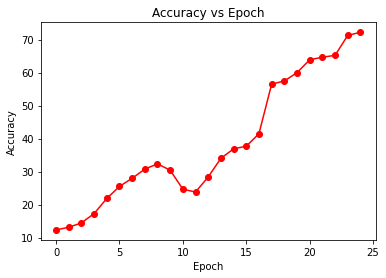

In [ ]:
plot_accuracy(accuracy, num_epoch=25)

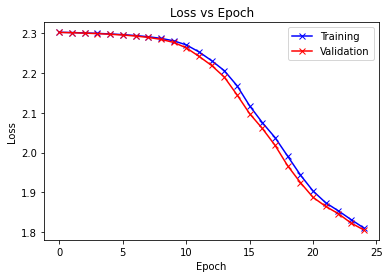

In [ ]:
plot_losses(train_loss, valid_loss) 

#### Optimizer : RMSProp

In [ ]:
# Initialize network
model3 = NN(input_size=input_size, num_classes=num_classes).to(device)
reset_network_params(model3)

# Loss and optimizer
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.RMSprop(model3.parameters(), lr=0.03, alpha=0.8, eps=1e-08, momentum=0)
train_loss, valid_loss, accuracy = TRAIN(model3, criterion3, optimizer3, num_epoch=10)


  2%|▏         | 19/782 [00:00<00:04, 186.27it/s]


Epoch :  0   Train Loss :  2.3486891975793083   Validation Loss :  2.34968591495684   Accuracy :  tensor(11.3500, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 193.81it/s]


Epoch :  1   Train Loss :  2.348698838287607   Validation Loss :  2.34968591495684   Accuracy :  tensor(11.3500, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 163.58it/s]


Epoch :  2   Train Loss :  2.34875878074285   Validation Loss :  2.349387348077859   Accuracy :  tensor(11.3500, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 148.15it/s]


Epoch :  3   Train Loss :  2.348638895832364   Validation Loss :  2.349387348077859   Accuracy :  tensor(11.3500, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:05, 152.26it/s]


Epoch :  4   Train Loss :  2.348519010921878   Validation Loss :  2.349088781198878   Accuracy :  tensor(11.3500, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 188.96it/s]


Epoch :  5   Train Loss :  2.34875878074285   Validation Loss :  2.34968591495684   Accuracy :  tensor(11.3500, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 179.50it/s]


Epoch :  6   Train Loss :  2.348698838287607   Validation Loss :  2.348790214319897   Accuracy :  tensor(11.3500, device='cuda:0') 



  2%|▏         | 14/782 [00:00<00:05, 138.85it/s]


Epoch :  7   Train Loss :  2.348578953377121   Validation Loss :  2.34968591495684   Accuracy :  tensor(11.3500, device='cuda:0') 



  2%|▏         | 14/782 [00:00<00:05, 137.54it/s]


Epoch :  8   Train Loss :  2.348818723198093   Validation Loss :  2.349088781198878   Accuracy :  tensor(11.3500, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 162.38it/s]



Epoch :  9   Train Loss :  2.34875878074285   Validation Loss :  2.3481930805619355   Accuracy :  tensor(11.3500, device='cuda:0') 

Time:  58.136496505998366


In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model3)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model3)*100:.2f}")

Accuracy on training set: 11.24
Accuracy on test set: 11.35


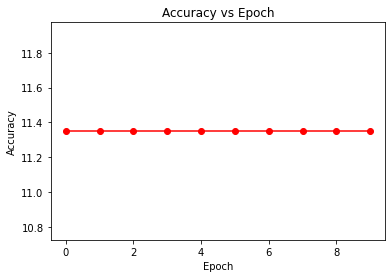

In [ ]:
plot_accuracy(accuracy, num_epoch=10)

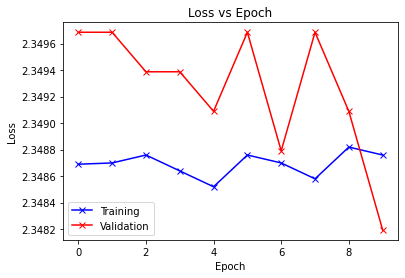

In [ ]:
plot_losses(train_loss, valid_loss) 

### Exponential annealing on the learning rate

In [ ]:
learning_rates = []
models = []
optimizers = []
criterions = []
n = 0.001
while (n < 1):
  learning_rates.append(n*2)
  
  # Initialize network
  tmp = NN(input_size=input_size, num_classes=num_classes, init_type="xavier").to(device)
  reset_network_params(tmp)
  models.append(tmp)

  # Loss and optimizer
  criterions.append(nn.CrossEntropyLoss())
  optimizers.append( optim.SGD(tmp.parameters(), lr=n, momentum=0.7, nesterov=True) )
  n = n * 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [ ]:
accuracies = []
for lr, mdl, opt, crit in zip(learning_rates, models, optimizers, criterions ):
  print("\nTRAINING MODEL WITH LEARNING RATE = =",lr,"\n")
  _, _, _ = TRAIN(mdl, crit, opt, num_epoch=10) 
  accuracies.append(check_accuracy(test_loader, mdl)*100) 
  #print(f"Accuracy on test set: {check_accuracy(test_loader, mdl)*100:.2f}")

  2%|▏         | 19/782 [00:00<00:04, 182.51it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.002 



  2%|▏         | 16/782 [00:00<00:04, 156.48it/s]


Epoch :  0   Train Loss :  2.300529053753904   Validation Loss :  2.2999857504656362   Accuracy :  tensor(16.2600, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 143.08it/s]


Epoch :  1   Train Loss :  2.29934040085434   Validation Loss :  2.298650260184221   Accuracy :  tensor(15.4800, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 143.95it/s]


Epoch :  2   Train Loss :  2.2977779115862247   Validation Loss :  2.2967716827514066   Accuracy :  tensor(13.8000, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 194.09it/s]


Epoch :  3   Train Loss :  2.2955075621300036   Validation Loss :  2.293992885358774   Accuracy :  tensor(11.5700, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 182.94it/s]


Epoch :  4   Train Loss :  2.2916900837208   Validation Loss :  2.2884471492402874   Accuracy :  tensor(10.0400, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 195.88it/s]


Epoch :  5   Train Loss :  2.283081077553732   Validation Loss :  2.2751712844629957   Accuracy :  tensor(9.8100, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 153.95it/s]


Epoch :  6   Train Loss :  2.2658964212593213   Validation Loss :  2.2568676016133304   Accuracy :  tensor(9.8200, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 176.80it/s]


Epoch :  7   Train Loss :  2.2510663728274958   Validation Loss :  2.244781134234872   Accuracy :  tensor(11.3600, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 147.49it/s]


Epoch :  8   Train Loss :  2.2409911555097537   Validation Loss :  2.235846003149725   Accuracy :  tensor(14.3000, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 169.53it/s]



Epoch :  9   Train Loss :  2.2328874214226024   Validation Loss :  2.2290383949401273   Accuracy :  tensor(16.3400, device='cuda:0') 

Time:  58.02149001699945


  2%|▏         | 18/782 [00:00<00:04, 179.65it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.004 



  3%|▎         | 20/782 [00:00<00:03, 195.29it/s]


Epoch :  0   Train Loss :  2.3020739363282536   Validation Loss :  2.3014192155971647   Accuracy :  tensor(14.2900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 194.80it/s]


Epoch :  1   Train Loss :  2.300865226084619   Validation Loss :  2.300172003970784   Accuracy :  tensor(19.6700, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 183.20it/s]


Epoch :  2   Train Loss :  2.299449200215547   Validation Loss :  2.2985565981287865   Accuracy :  tensor(22.9600, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 154.87it/s]


Epoch :  3   Train Loss :  2.297407786254688   Validation Loss :  2.2959723077761898   Accuracy :  tensor(23.2000, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.63it/s]


Epoch :  4   Train Loss :  2.2937483561923133   Validation Loss :  2.2907427496211543   Accuracy :  tensor(19.4300, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.08it/s]


Epoch :  5   Train Loss :  2.2839572210141155   Validation Loss :  2.2722553584226377   Accuracy :  tensor(11.0900, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 159.60it/s]


Epoch :  6   Train Loss :  2.255036082414105   Validation Loss :  2.2401566186528297   Accuracy :  tensor(22.3200, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 155.80it/s]


Epoch :  7   Train Loss :  2.2295690823698897   Validation Loss :  2.217571335992995   Accuracy :  tensor(32.3600, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 198.47it/s]


Epoch :  8   Train Loss :  2.199543873062524   Validation Loss :  2.17487340520142   Accuracy :  tensor(32.8400, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 186.14it/s]



Epoch :  9   Train Loss :  2.1431674643245806   Validation Loss :  2.116204018805437   Accuracy :  tensor(39.1100, device='cuda:0') 

Time:  56.25731689500026


  2%|▏         | 18/782 [00:00<00:04, 176.00it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.008 



  3%|▎         | 20/782 [00:00<00:03, 193.38it/s]


Epoch :  0   Train Loss :  2.3015574689411444   Validation Loss :  2.300172420064355   Accuracy :  tensor(20.0800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 195.78it/s]


Epoch :  1   Train Loss :  2.2981699936835054   Validation Loss :  2.2955626682111414   Accuracy :  tensor(26.3100, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 178.52it/s]


Epoch :  2   Train Loss :  2.2900668385693486   Validation Loss :  2.2809272799522256   Accuracy :  tensor(19.9800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 191.79it/s]


Epoch :  3   Train Loss :  2.249128208440893   Validation Loss :  2.2119784309605883   Accuracy :  tensor(25.9900, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 178.31it/s]


Epoch :  4   Train Loss :  2.160388019993482   Validation Loss :  2.0878959127292513   Accuracy :  tensor(39.4200, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 173.28it/s]


Epoch :  5   Train Loss :  2.0075135250835467   Validation Loss :  1.922506726471482   Accuracy :  tensor(64.1600, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 197.52it/s]


Epoch :  6   Train Loss :  1.8674811653773804   Validation Loss :  1.8133044045442228   Accuracy :  tensor(70.9300, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 191.69it/s]


Epoch :  7   Train Loss :  1.7891685534316255   Validation Loss :  1.7678480695007712   Accuracy :  tensor(73.0700, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.48it/s]


Epoch :  8   Train Loss :  1.7596264460202677   Validation Loss :  1.7480174675109281   Accuracy :  tensor(74.0500, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 178.57it/s]



Epoch :  9   Train Loss :  1.7443582976565641   Validation Loss :  1.7372227755321819   Accuracy :  tensor(74.5200, device='cuda:0') 

Time:  55.67525895499966


  2%|▏         | 18/782 [00:00<00:04, 172.06it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.016 



  3%|▎         | 20/782 [00:00<00:03, 196.59it/s]


Epoch :  0   Train Loss :  2.2986181748797523   Validation Loss :  2.291927245012514   Accuracy :  tensor(17.2200, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 153.23it/s]


Epoch :  1   Train Loss :  2.249650195126643   Validation Loss :  2.153534535389797   Accuracy :  tensor(36.8500, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 162.72it/s]


Epoch :  2   Train Loss :  1.9984297714269985   Validation Loss :  1.870145606387193   Accuracy :  tensor(64.5800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 191.01it/s]


Epoch :  3   Train Loss :  1.7934359714503179   Validation Loss :  1.755355279157116   Accuracy :  tensor(73.7400, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 194.95it/s]


Epoch :  4   Train Loss :  1.7394054914679369   Validation Loss :  1.7298675638854883   Accuracy :  tensor(74.8400, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 194.32it/s]


Epoch :  5   Train Loss :  1.7231575366481187   Validation Loss :  1.7212257711750687   Accuracy :  tensor(75.3400, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 177.23it/s]


Epoch :  6   Train Loss :  1.7153108522410283   Validation Loss :  1.7149050676139297   Accuracy :  tensor(75.4500, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 163.94it/s]


Epoch :  7   Train Loss :  1.7106343651061777   Validation Loss :  1.711849167088794   Accuracy :  tensor(75.5800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 192.55it/s]


Epoch :  8   Train Loss :  1.7075781343538132   Validation Loss :  1.7085606922769243   Accuracy :  tensor(75.9100, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 172.88it/s]



Epoch :  9   Train Loss :  1.7049585809488126   Validation Loss :  1.7072445564209275   Accuracy :  tensor(76., device='cuda:0') 

Time:  57.27888236200124


  2%|▏         | 18/782 [00:00<00:04, 172.67it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.032 



  2%|▏         | 17/782 [00:00<00:04, 167.73it/s]


Epoch :  0   Train Loss :  2.274535882198597   Validation Loss :  2.1566987128774073   Accuracy :  tensor(30.7200, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 184.48it/s]


Epoch :  1   Train Loss :  1.8719560455178361   Validation Loss :  1.7447526477704383   Accuracy :  tensor(74.9100, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 198.14it/s]


Epoch :  2   Train Loss :  1.7263874765247336   Validation Loss :  1.7179322402188733   Accuracy :  tensor(76.0300, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 193.97it/s]


Epoch :  3   Train Loss :  1.7106895820259134   Validation Loss :  1.7091800209822927   Accuracy :  tensor(76.5000, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 194.25it/s]


Epoch :  4   Train Loss :  1.6892855822887567   Validation Loss :  1.6501535116487247   Accuracy :  tensor(83.2600, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 194.63it/s]


Epoch :  5   Train Loss :  1.6351546418026586   Validation Loss :  1.6333120871501363   Accuracy :  tensor(84.5000, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 162.30it/s]


Epoch :  6   Train Loss :  1.6095624069118744   Validation Loss :  1.589115202047263   Accuracy :  tensor(89.3300, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.65it/s]


Epoch :  7   Train Loss :  1.57159440779625   Validation Loss :  1.5708416525725346   Accuracy :  tensor(90.9000, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 192.82it/s]


Epoch :  8   Train Loss :  1.5600245477598342   Validation Loss :  1.5651455791133224   Accuracy :  tensor(91.3800, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 181.93it/s]



Epoch :  9   Train Loss :  1.5530761305023641   Validation Loss :  1.5586037575059635   Accuracy :  tensor(92.0000, device='cuda:0') 

Time:  57.08188157500081


  3%|▎         | 20/782 [00:00<00:03, 197.36it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.064 



  2%|▏         | 19/782 [00:00<00:04, 187.96it/s]


Epoch :  0   Train Loss :  2.106762062863011   Validation Loss :  1.7621156417640151   Accuracy :  tensor(76.2000, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 185.78it/s]


Epoch :  1   Train Loss :  1.6683248647338593   Validation Loss :  1.6425700711596543   Accuracy :  tensor(83.6200, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 179.60it/s]


Epoch :  2   Train Loss :  1.6289337855165877   Validation Loss :  1.6283441842741269   Accuracy :  tensor(84.5500, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:05, 150.85it/s]


Epoch :  3   Train Loss :  1.619178529590597   Validation Loss :  1.6198509612660499   Accuracy :  tensor(85.1900, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 178.43it/s]


Epoch :  4   Train Loss :  1.6140652722714808   Validation Loss :  1.6199697362389534   Accuracy :  tensor(85.0100, device='cuda:0') 



  2%|▏         | 14/782 [00:00<00:05, 137.17it/s]


Epoch :  5   Train Loss :  1.6102810777971506   Validation Loss :  1.6128541299491932   Accuracy :  tensor(85.7100, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 165.68it/s]


Epoch :  6   Train Loss :  1.6075193593874002   Validation Loss :  1.611564373514455   Accuracy :  tensor(85.6800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.93it/s]


Epoch :  7   Train Loss :  1.6044484443981628   Validation Loss :  1.6106342137998837   Accuracy :  tensor(85.6600, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:05, 153.10it/s]


Epoch :  8   Train Loss :  1.6021513970916534   Validation Loss :  1.6073799391461026   Accuracy :  tensor(85.9600, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 183.52it/s]



Epoch :  9   Train Loss :  1.6002277954460105   Validation Loss :  1.6058888868161827   Accuracy :  tensor(86.0300, device='cuda:0') 

Time:  56.97672624600091


  2%|▏         | 19/782 [00:00<00:04, 187.59it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.128 



  3%|▎         | 20/782 [00:00<00:04, 188.71it/s]


Epoch :  0   Train Loss :  1.9292214246052306   Validation Loss :  1.7153465307442246   Accuracy :  tensor(75.2700, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.12it/s]


Epoch :  1   Train Loss :  1.7068426182202976   Validation Loss :  1.7032484157829528   Accuracy :  tensor(75.9800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 194.79it/s]


Epoch :  2   Train Loss :  1.6987905811775676   Validation Loss :  1.6982628600612568   Accuracy :  tensor(76.2900, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 158.00it/s]


Epoch :  3   Train Loss :  1.6949357291316742   Validation Loss :  1.7003945613362987   Accuracy :  tensor(76.0900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.34it/s]


Epoch :  4   Train Loss :  1.691271275358127   Validation Loss :  1.6915491773824023   Accuracy :  tensor(76.7200, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 145.01it/s]


Epoch :  5   Train Loss :  1.6878280385071054   Validation Loss :  1.691939199806019   Accuracy :  tensor(76.7300, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 182.47it/s]


Epoch :  6   Train Loss :  1.6845912928776363   Validation Loss :  1.6879849395934183   Accuracy :  tensor(77.1900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 192.04it/s]


Epoch :  7   Train Loss :  1.6820751695376832   Validation Loss :  1.688887479198966   Accuracy :  tensor(77., device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 178.26it/s]


Epoch :  8   Train Loss :  1.6799761274891436   Validation Loss :  1.6839757831233322   Accuracy :  tensor(77.1200, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 166.12it/s]



Epoch :  9   Train Loss :  1.6353112722906615   Validation Loss :  1.6198862122881943   Accuracy :  tensor(84.2000, device='cuda:0') 

Time:  57.186323278998316


  3%|▎         | 20/782 [00:00<00:03, 197.59it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.256 



  2%|▏         | 19/782 [00:00<00:04, 180.21it/s]


Epoch :  0   Train Loss :  1.7538339902677804   Validation Loss :  1.5706046713385613   Accuracy :  tensor(90.4800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 195.21it/s]


Epoch :  1   Train Loss :  1.5521045717436943   Validation Loss :  1.5417589875543194   Accuracy :  tensor(92.8900, device='cuda:0') 



  2%|▏         | 13/782 [00:00<00:06, 125.84it/s]


Epoch :  2   Train Loss :  1.5319628997531998   Validation Loss :  1.532803169481314   Accuracy :  tensor(93.4200, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 154.35it/s]


Epoch :  3   Train Loss :  1.520564404442487   Validation Loss :  1.5286580719006289   Accuracy :  tensor(94.1800, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 189.57it/s]


Epoch :  4   Train Loss :  1.5124761716788993   Validation Loss :  1.5219835718725896   Accuracy :  tensor(94.7300, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 155.47it/s]


Epoch :  5   Train Loss :  1.5069870313110254   Validation Loss :  1.517140995165345   Accuracy :  tensor(94.9100, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 145.57it/s]


Epoch :  6   Train Loss :  1.5012995341549749   Validation Loss :  1.5290508589167504   Accuracy :  tensor(93.9800, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 191.48it/s]


Epoch :  7   Train Loss :  1.4984032484271643   Validation Loss :  1.508002435325817   Accuracy :  tensor(95.8300, device='cuda:0') 



  2%|▏         | 14/782 [00:00<00:05, 139.53it/s]


Epoch :  8   Train Loss :  1.495566217185896   Validation Loss :  1.5054928375657197   Accuracy :  tensor(96.1500, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 176.18it/s]



Epoch :  9   Train Loss :  1.4934044631240924   Validation Loss :  1.505903275908938   Accuracy :  tensor(96.0100, device='cuda:0') 

Time:  56.95056928699887


  3%|▎         | 20/782 [00:00<00:03, 191.60it/s]


TRAINING MODEL WITH LEARNING RATE = = 0.512 



  3%|▎         | 20/782 [00:00<00:03, 194.33it/s]


Epoch :  0   Train Loss :  1.6909526726778816   Validation Loss :  1.6187244737224213   Accuracy :  tensor(85.9000, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 193.90it/s]


Epoch :  1   Train Loss :  1.5392055072442954   Validation Loss :  1.540369884223695   Accuracy :  tensor(92.5600, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 171.75it/s]


Epoch :  2   Train Loss :  1.5214274911319507   Validation Loss :  1.5205232072028385   Accuracy :  tensor(94.8400, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 197.13it/s]


Epoch :  3   Train Loss :  1.511601534188556   Validation Loss :  1.5220266383165006   Accuracy :  tensor(94.7000, device='cuda:0') 



  2%|▏         | 17/782 [00:00<00:04, 169.82it/s]


Epoch :  4   Train Loss :  1.5066644034117385   Validation Loss :  1.5166477595165277   Accuracy :  tensor(95.2300, device='cuda:0') 



  2%|▏         | 19/782 [00:00<00:04, 187.55it/s]


Epoch :  5   Train Loss :  1.503042317869718   Validation Loss :  1.5055368614804214   Accuracy :  tensor(96.2600, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 192.32it/s]


Epoch :  6   Train Loss :  1.4989653909602738   Validation Loss :  1.505003871431776   Accuracy :  tensor(96.0600, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 196.20it/s]


Epoch :  7   Train Loss :  1.4964285689546628   Validation Loss :  1.5233027661681935   Accuracy :  tensor(94., device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 173.97it/s]


Epoch :  8   Train Loss :  1.4967687430284213   Validation Loss :  1.503953691500767   Accuracy :  tensor(95.8800, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 183.97it/s]



Epoch :  9   Train Loss :  1.4939477946752173   Validation Loss :  1.5018640133985288   Accuracy :  tensor(96.2300, device='cuda:0') 

Time:  56.112263994000386


  2%|▏         | 19/782 [00:00<00:04, 189.13it/s]


TRAINING MODEL WITH LEARNING RATE = = 1.024 



  3%|▎         | 20/782 [00:00<00:03, 196.03it/s]


Epoch :  0   Train Loss :  1.6336233574716026   Validation Loss :  1.6478624807041922   Accuracy :  tensor(82.0100, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 197.90it/s]


Epoch :  1   Train Loss :  1.5500833468364024   Validation Loss :  1.5491704143536318   Accuracy :  tensor(91.4900, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 195.78it/s]


Epoch :  2   Train Loss :  1.5425314601425015   Validation Loss :  1.5534881376157141   Accuracy :  tensor(91.5800, device='cuda:0') 



  2%|▏         | 18/782 [00:00<00:04, 170.40it/s]


Epoch :  3   Train Loss :  1.5507667765897863   Validation Loss :  1.5599427230798515   Accuracy :  tensor(90.6200, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 143.11it/s]


Epoch :  4   Train Loss :  1.5563667011078057   Validation Loss :  1.563188418461259   Accuracy :  tensor(90.1200, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 148.92it/s]


Epoch :  5   Train Loss :  1.5649256047690312   Validation Loss :  1.5794252119246561   Accuracy :  tensor(88.7500, device='cuda:0') 



  2%|▏         | 15/782 [00:00<00:05, 144.39it/s]


Epoch :  6   Train Loss :  1.5680023210737712   Validation Loss :  1.551469134676988   Accuracy :  tensor(91.2100, device='cuda:0') 



  3%|▎         | 20/782 [00:00<00:03, 193.06it/s]


Epoch :  7   Train Loss :  1.588363468037237   Validation Loss :  1.676530459883866   Accuracy :  tensor(78.4300, device='cuda:0') 



  2%|▏         | 16/782 [00:00<00:04, 157.88it/s]


Epoch :  8   Train Loss :  1.58934041026913   Validation Loss :  1.5970703348232682   Accuracy :  tensor(87.4200, device='cuda:0') 



100%|██████████| 782/782 [00:04<00:00, 174.96it/s]



Epoch :  9   Train Loss :  1.60741537123385   Validation Loss :  1.614584985811999   Accuracy :  tensor(85.5900, device='cuda:0') 

Time:  58.28463398900021


In [ ]:
accuracies

[tensor(16.3400, device='cuda:0'),
 tensor(39.1100, device='cuda:0'),
 tensor(74.5200, device='cuda:0'),
 tensor(76., device='cuda:0'),
 tensor(92.0000, device='cuda:0'),
 tensor(86.0300, device='cuda:0'),
 tensor(84.2000, device='cuda:0'),
 tensor(96.0100, device='cuda:0'),
 tensor(96.2300, device='cuda:0'),
 tensor(85.5900, device='cuda:0')]

### Plotting accuracy differnt learning rate obtained as a result of exponential annealing

Text(0.5, 1.0, 'Accuracy vs Learning rate')

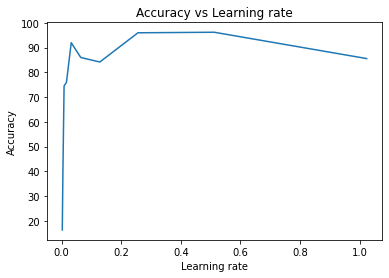

In [ ]:
plt.plot( learning_rates, accuracies )
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Learning rate")

# Part 2

#### Autoencoder used is same as in question 2

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(AutoEncoder, self).__init__()
        #Encoder
        self.enc1 = nn.Linear(784, 256) # Input image (28*28 = 784)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)

        #Decoder 
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784) # Output image (28*28 = 784)


    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))

        return x



In [ ]:
# Hyperparameters of our neural network which depends on the dataset, and
# also just experimenting to see what works well (learning rate for example).
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64

### Funtion to reconstruct test images and calculate total MSE 

In [ ]:
def test_image_reconstruct(model, test_loader):
     tot_recons_err = 0.0
     all_reconstructions = []
     for batch in test_loader:
        img, _ = batch
        img = img.to(device)
        img = img.reshape(img.shape[0], -1)
        outputs = model(img)
        actual = img.cpu().numpy()
        reconstructed = outputs.detach().cpu().numpy()
        tot_recons_err += np.sum(np.sqrt(np.sum((actual - reconstructed)**2, axis=1)))
        for img in reconstructed:
          all_reconstructions.append(img.reshape((28,28)))

     return all_reconstructions, tot_recons_err

### Function to display 20 random reconstructed images

In [ ]:
def show_sample_reconstructions(reconstrucions):
  idx = random.sample(range(1, 9999), 20)
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  for i in range(0, columns*rows ):
      img = np.random.randint(10, size=(h,w))
      fig.add_subplot(rows, columns, i+1) 
      #print(idx[i])
      plt.imshow(reconstrucions[idx[i]]) 
  plt.show()

In [ ]:
def plot_loss(train_loss, num_epoch):
  plt.plot(train_loss, '-ro')
  plt.xlabel("Epoch")
  plt.ylabel("Train loss")
  plt.title("Train Loss vs Epoch")

### Perparing test dataset loader with the reconstructed images from autoencoder 

In [ ]:
def get_reconstructed_images_loader(all_reconstrucions):
    X = np.zeros((1, 1, 28, 28))
    Y = np.zeros(1)
    for img in all_reconstrucions:
      img = img.reshape((1,1,28,28))
      X = np.vstack((X,img))
    X = X[1:,:]
    
    with torch.no_grad():
        for _, y in test_loader2:
            y = y.to(device=device)
            targets = y.cpu().numpy()
            Y = np.append(Y, targets)
    Y = Y[1:] 
    print(X.shape, Y.shape)
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    my_dataset = TensorDataset(X,Y)
    recons_test_loader = DataLoader(my_dataset, batch_size=64 )
    return my_dataset, recons_test_loader

### Function to train Autoencoder

In [ ]:
def train_model(model,  criterion, optimizer,  Epochs=10):
    train_loss = []
    for epoch in range(Epochs):
        running_loss = 0.0
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            #print(img.shape)
            #break
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        #break
        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, Epochs, loss))

        #if (epoch == Epochs-1):
        #    save_decod_img(outputs.cpu().data, epoch)

    return train_loss

In [ ]:
autoEnc1 = AutoEncoder()
autoEnc1.to(device)
reset_network_params(autoEnc1)

criterionEnc1 = nn.MSELoss()
optimizerEnc1 = optim.Adam(autoEnc1.parameters(), lr=0.001)
train_loss = train_model(autoEnc1, criterionEnc1, optimizerEnc1, Epochs=25)
#train_loss = training(model, train_loader, 10)

Epoch 1 of 25, Train Loss: 0.058
Epoch 2 of 25, Train Loss: 0.039
Epoch 3 of 25, Train Loss: 0.032
Epoch 4 of 25, Train Loss: 0.029
Epoch 5 of 25, Train Loss: 0.027
Epoch 6 of 25, Train Loss: 0.026
Epoch 7 of 25, Train Loss: 0.026
Epoch 8 of 25, Train Loss: 0.025
Epoch 9 of 25, Train Loss: 0.024
Epoch 10 of 25, Train Loss: 0.023
Epoch 11 of 25, Train Loss: 0.023
Epoch 12 of 25, Train Loss: 0.022
Epoch 13 of 25, Train Loss: 0.022
Epoch 14 of 25, Train Loss: 0.021
Epoch 15 of 25, Train Loss: 0.021
Epoch 16 of 25, Train Loss: 0.021
Epoch 17 of 25, Train Loss: 0.020
Epoch 18 of 25, Train Loss: 0.020
Epoch 19 of 25, Train Loss: 0.019
Epoch 20 of 25, Train Loss: 0.019
Epoch 21 of 25, Train Loss: 0.019
Epoch 22 of 25, Train Loss: 0.019
Epoch 23 of 25, Train Loss: 0.019
Epoch 24 of 25, Train Loss: 0.018
Epoch 25 of 25, Train Loss: 0.018


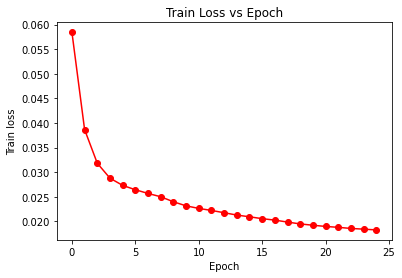

In [ ]:
plot_loss(train_loss, 10)

In [ ]:
test_dataset2 = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader2 = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
all_reconstrucions, tot_recons_err =  test_image_reconstruct(autoEnc1, test_loader2)
print("Total Reconstrucion Error : ",tot_recons_err )
print("Average Reconstrucion Error : ",tot_recons_err/10000 )

Total Reconstrucion Error :  37040.28690338135
Average Reconstrucion Error :  3.7040286903381348


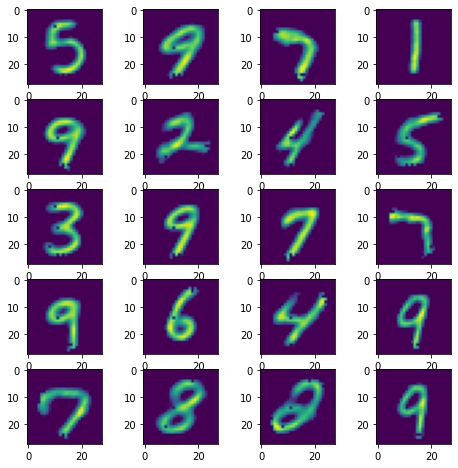

In [ ]:
show_sample_reconstructions(all_reconstrucions)

In [ ]:
my_dataset, recons_test_loader = get_reconstructed_images_loader(all_reconstrucions)

Accuracy :  tensor(94.2700, device='cuda:0')


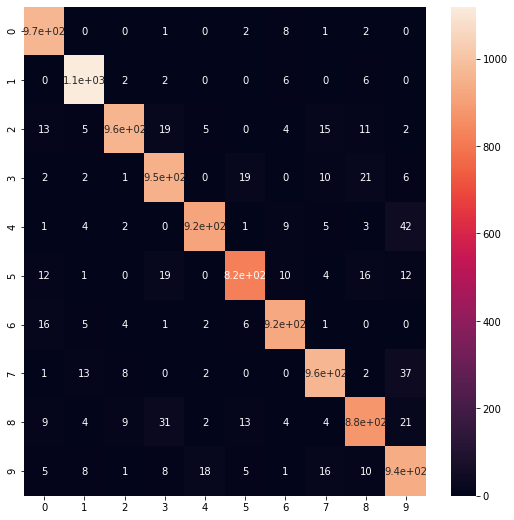

In [ ]:
acc = check_accuracy(recons_test_loader, model1)*100
print("Accuracy : ",acc)
get_confusion_matrix(recons_test_loader, model1)

### As we observe, since the average reconstruction loss per image is not much(approx. 7), so the classification using the reconstruction images also gives equally high accuracy as when tested on actual test images.